In [3]:
import os
import pygmt
import imageio
import xarray as xr
import numpy as np

from scripts import getTectonicInfo as tmaps

> In cases where a constrained simulation was ran, `goSPL` will output the required tectonic forcing (uplift/subsidence) to *match* the elevation with the paleo-elevation one every time a paleo-elevation is provided.


<img src="img/extractTec.png"
     alt="Extracting tectonic forcing from constrained model"
     style="float: left; margin-right: 10px;" />



This notebook helps you extract for each time step this tectonic forcing that can then be used to run an *unconstrained* model by adding this new forcing to the background tectonic obtained from the geometrical solution.  Extract the tectonic information related to the surface processes model to run *unconstrained* model.

To do this, a Python class (`scripts/getTectonicInfo`) is used. In most cases, we do want to account for the large wave-lenght components of this tectonic signal more than the higher ones that correspond to some specific geomorphic attributes which are actually not considered in the paleo-elevation model. 

For example, the associated tectonic related to a *constrained* model will try to remove the surface expressions of incised valleys or large deltaic deposits, which are created by surface processes. These features are obviously important to retain in our models!


To filter the *constrained* model, we need to interpolate the signal from the unstructured `goSPL` mesh to a regular grid which resolution (`res` below) is given in degrees. 

In [2]:
# Regular grid resolution
res = 0.1

# Time step at which consttrained paleo-elevation are provided
dt = 5.e6

# Constrained model output folder
outputDir = 'output5'

# Initial goSPL mesh 
npdata = '../2-inputgen/gospldata/mesh_9_100Ma.npz'

# Initialise the Python class used to extract the tectonic from constrained model
tmap = tmaps.getTectonicInfo(npdata, outputDir, dt, res)

Once the class has been initialised, we will run a loop over all time steps (output) and perform the filtering using a lowpass Gaussian Filter that eliminates high frequency (sharp) features. 

The filtering takes 2 arguments:

+ a smoothing value (`smth`), and 
+ a factor value (`factor`).

First let's create a directory where we will store the tectonic forcing for our *unconstrained* simulation:

In [7]:
# Output folder where new tectonic forcing will be stored
folder = 'unconstrained'

# Check whether the specified folder exists or not
isExist = os.path.exists(folder)

if not isExist:
  # Create the new directory because it does not exist 
  os.makedirs(folder)

Now we will do a test on a specific time step:

In [9]:
time = np.arange(100, 0, -5)

# Picking a specific step
step = 10

# Map the tectonic information on a regular mesh
# Note that the tectonic that needs to be applied at a specific step k is read at step k+1
tmap.mapRegular(step+1)
    
# Apply the lowpass Gaussian filtering
tmap.updatePaleoTec(smth=6, factor=1.5)
    
# Interpolate the modified tectonic signal on goSPL mesh
tmap.remapTec()

# Save the modified tectonic signal from the goSPL mesh in a file
name = folder+'/tecto_9_'+str(time[step])+'Ma'
    
# The new tectonic (ntec) is added to the background tectonic from the geometrical solution
np.savez_compressed(name, t=(tmap.ntec)+(tmap.uplift*tmap.dt))

Let's plot the tectonic forcings obtained from the code above:

Geometrical tectonic forcing map


grdgradient [WARNING]: Longitude range too small; geographic boundary condition changed to natural.
grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.
grdcontour [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


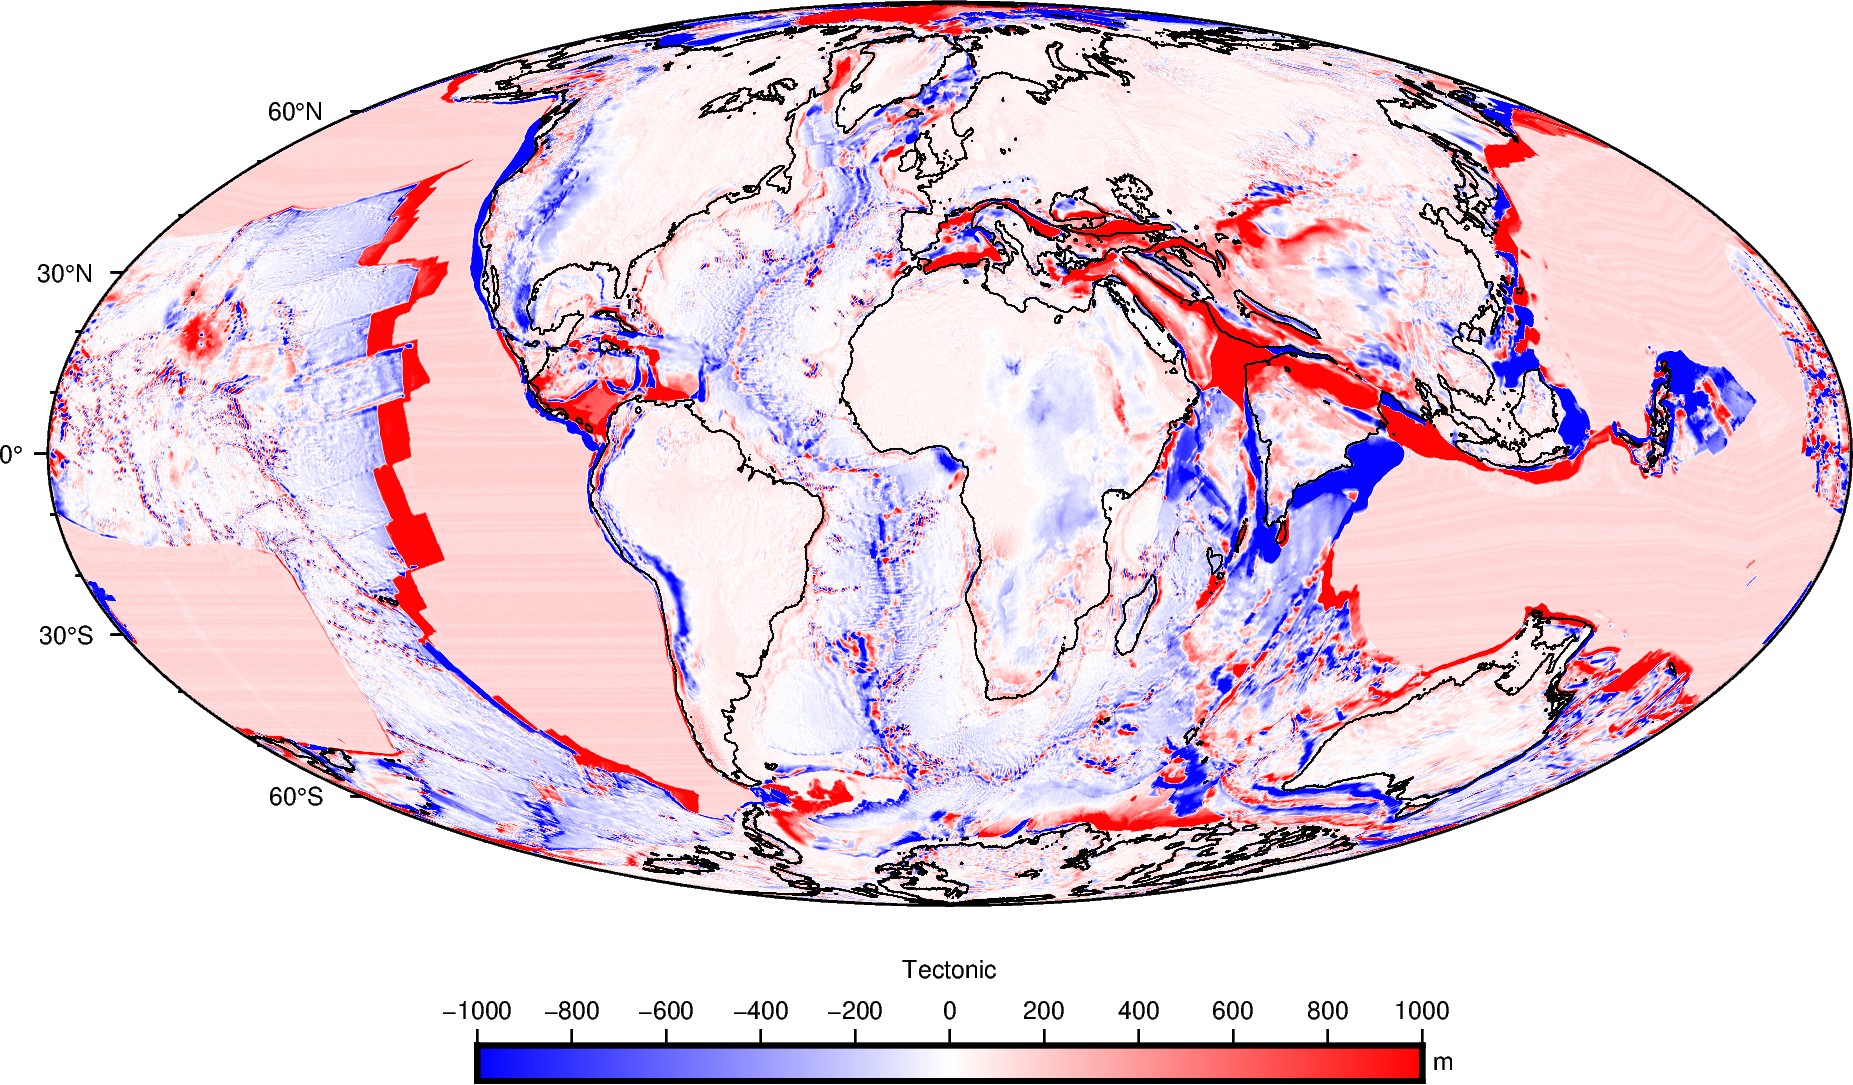

Constrained tectonic map


grdgradient [WARNING]: Longitude range too small; geographic boundary condition changed to natural.
grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.
grdcontour [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


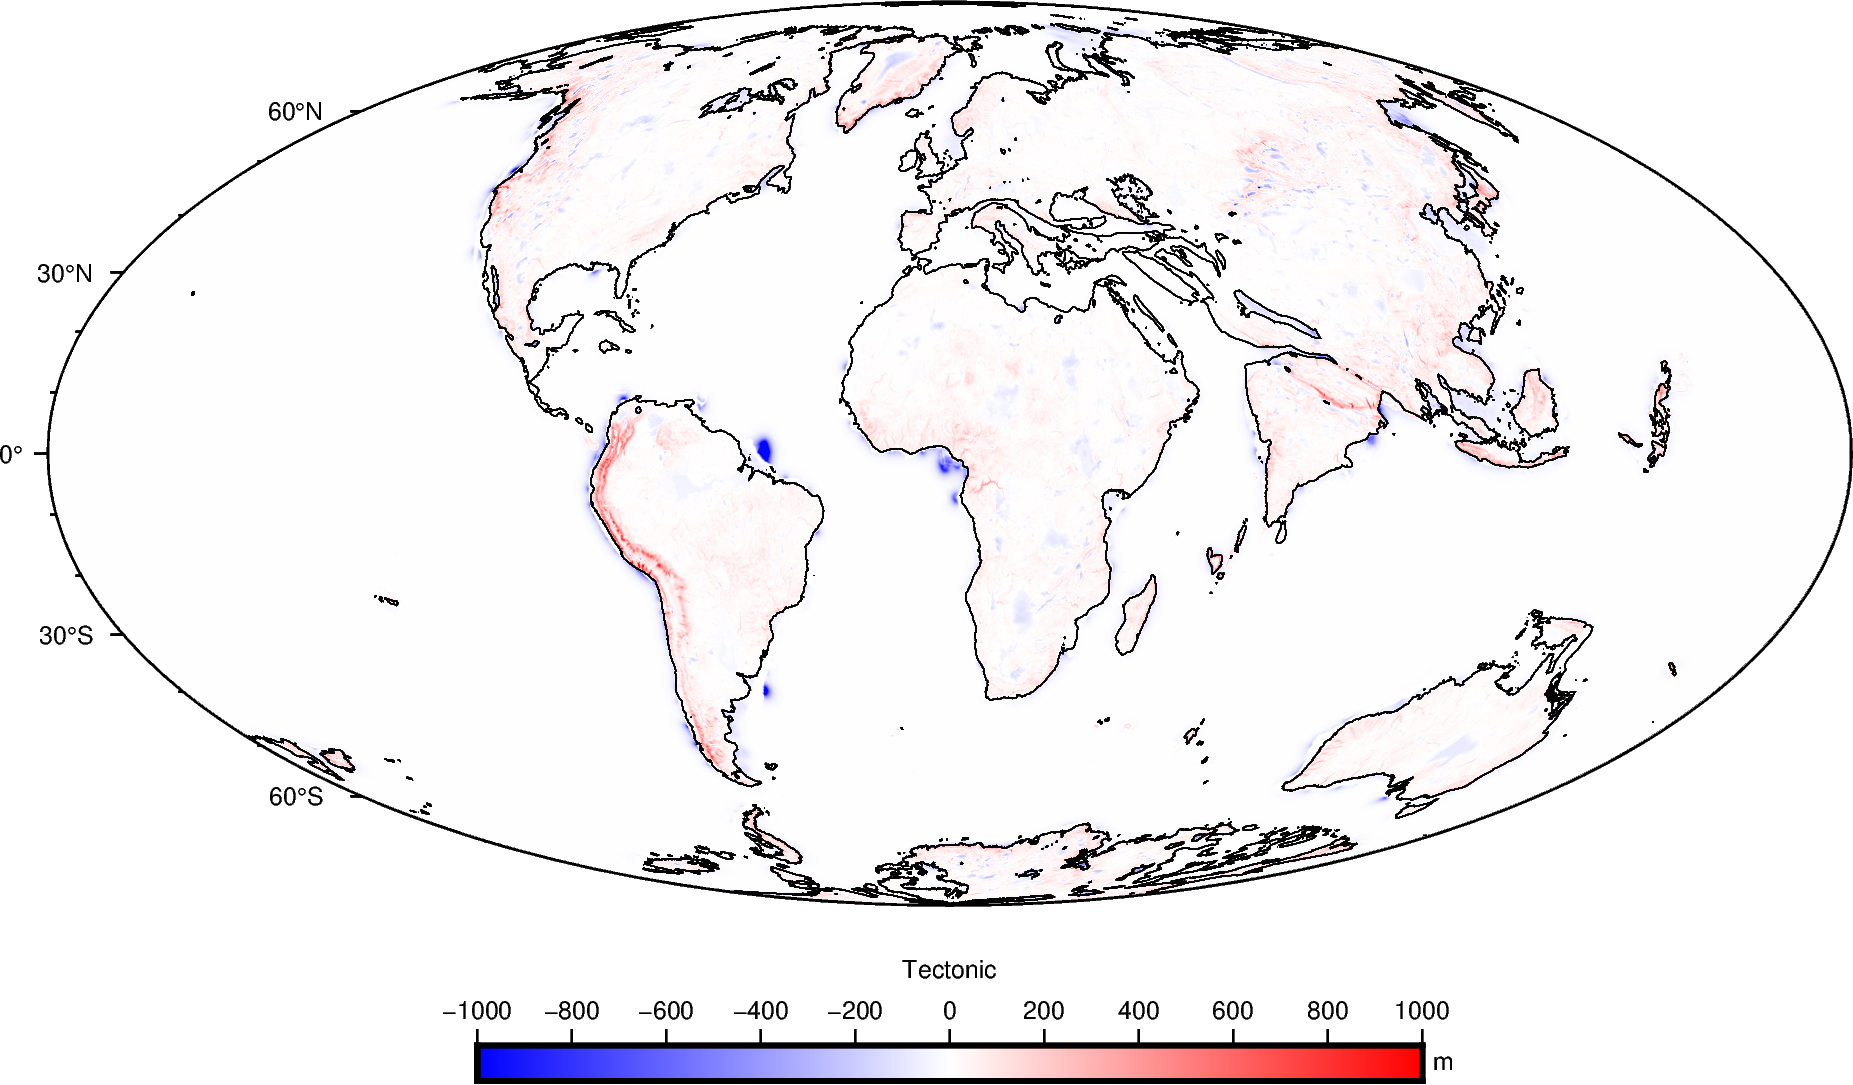

Filtered tectonic map to apply for the unconstrained model


grdgradient [WARNING]: Longitude range too small; geographic boundary condition changed to natural.
grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.
grdcontour [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


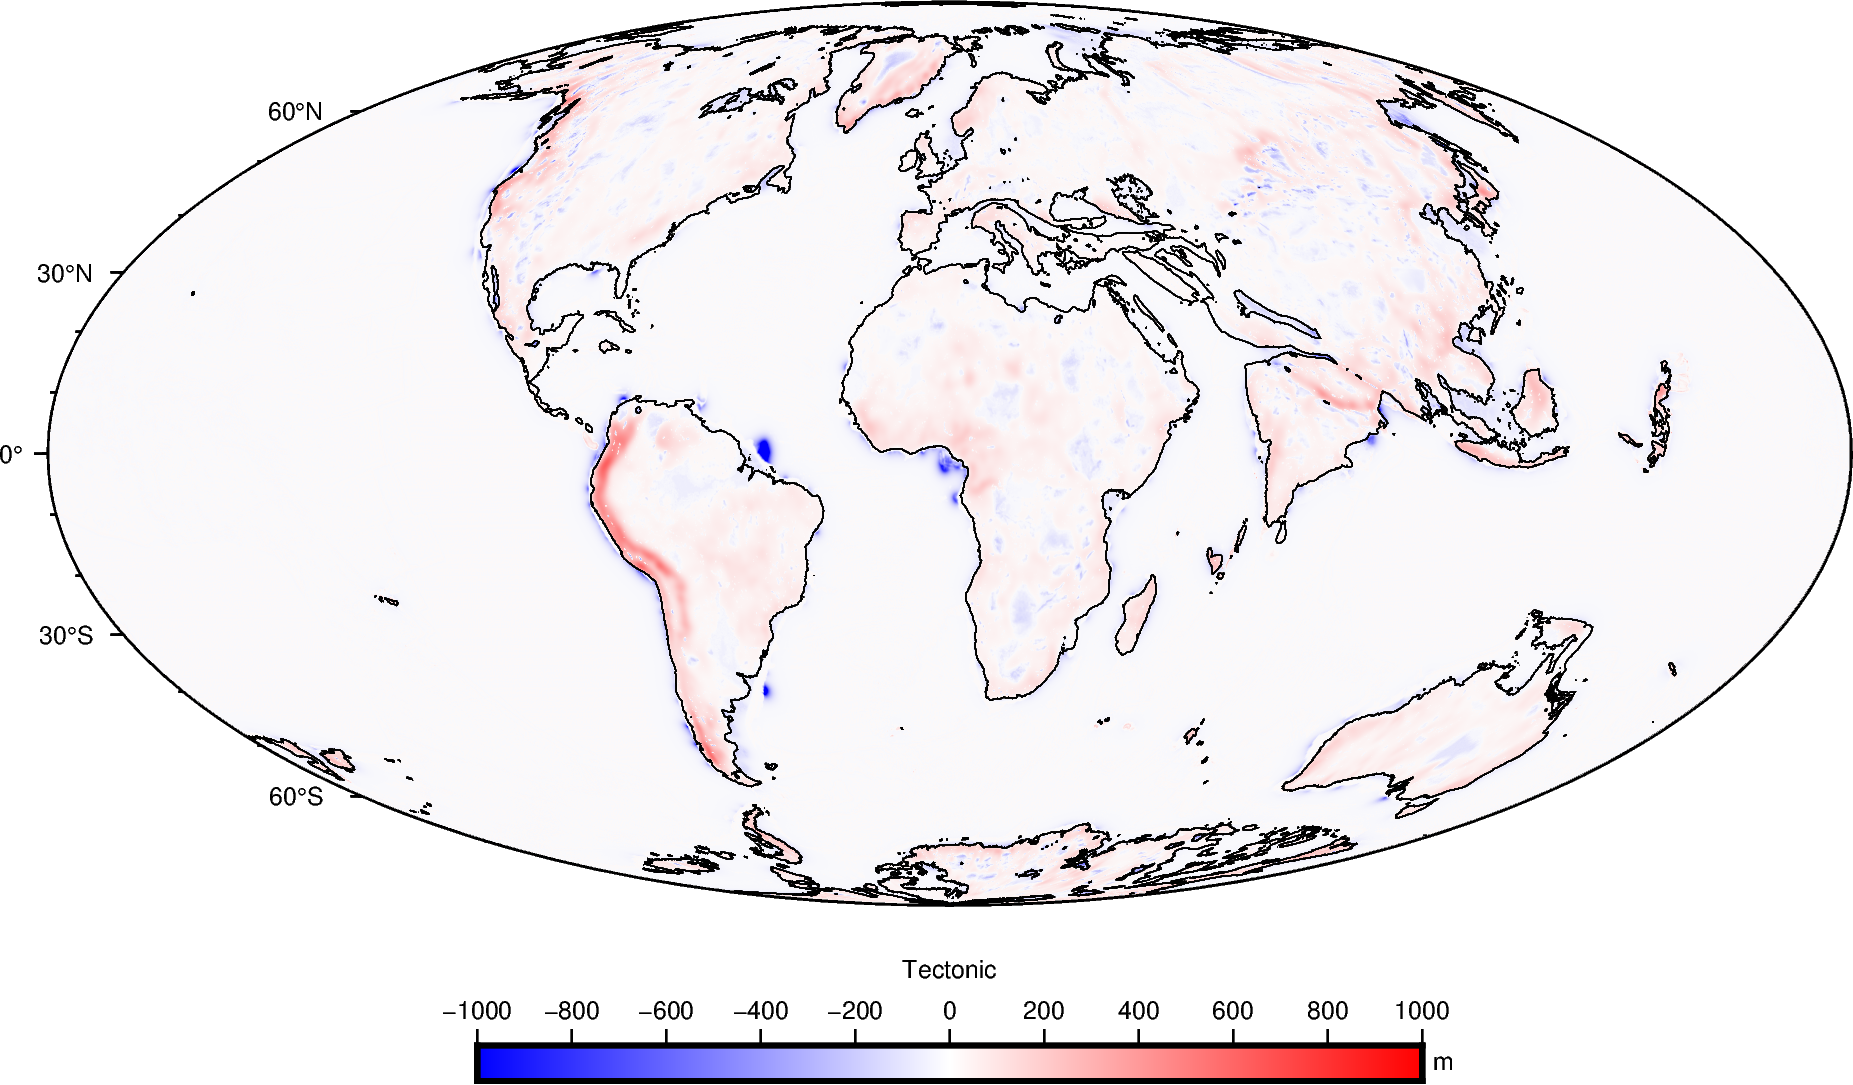

In [14]:
def plotTectonic(tecdata, zdata):

    fig = pygmt.Figure()

    with pygmt.config(COLOR_FOREGROUND="red", COLOR_BACKGROUND="blue"):
        pygmt.makecpt(
            cmap="polar", 
            series=[-1000, 1000],
        )

        with pygmt.config(FONT='6p,Helvetica,black'):
            fig.basemap(region='d', projection='W6i', frame='afg')
            fig.grdimage(tecdata, shading='+a345+nt1+m0', frame=False)

            # Add contour
            fig.grdcontour(
                interval=0.1,
                grid=zdata,
                limit=[-0.1, 0.1],
                pen="0.25p,black"
            )

            fig.colorbar(position="jBC+o0c/-1.5c+w8c/0.3c+h",frame=["a200", "x+lTectonic", "y+lm"])

    fig.show(width=1000) #fig.show(dpi=500, width=1000)
    

print('Geometrical tectonic forcing map')
plotTectonic(tmap.tecds, tmap.zds)

print('Constrained tectonic map')
plotTectonic(tmap.paleotecds, tmap.zds)

print('Filtered tectonic map to apply for the unconstrained model')
plotTectonic(tmap.newtecds, tmap.zds)

We can run this in a loop if the Gaussian filter parameters are kept the same for each time interval:

In [ ]:
time = np.arange(100, 0, -5)

for k in range(len(time)):
    
    # Map the tectonic information on a regular mesh 
    tmap.mapRegular(step = k+1)
    
    # Apply the lowpass Gaussian filtering
    tmap.updatePaleoTec(smth=6, factor=1.5)
    
    # Interpolate the modified tectonic signal on goSPL mesh
    tmap.remapTec()
    
    # Save the modified tectonic signal from the goSPL mesh in a file
    name = folder+'/tecto_9_'+str(time[k])+'Ma'
    
    # The new tectonic (ntec) is added to the background tectonic from the geometrical solution
    np.savez_compressed(name, t=(tmap.ntec)+(tmap.uplift*tmap.dt))

The new created tectonic files could then be used to run *unconstrained* simulation with `goSPL`